# Learning Fine-grained Image Similarity with Deep Ranking

Conserve RAM by switching off caching.

In [0]:
from video699.configuration import CONFIGURATION


CONFIGURATION['ImageFileDocumentPage']['lru_cache_maxsize'] = '0'
CONFIGURATION['ScreenABC']['lru_cache_maxsize'] = '0'

## Constructing the model
Construct the deep model from the “Learning Fine-grained Image Similarity with Deep Ranking” paper by Wang et al. (2014).

In [0]:
from keras.applications.vgg16 import VGG16
from keras.layers import (
    concatenate,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    Lambda,
    MaxPool2D
)
from keras.models import Model
from keras import backend


def deep_rank_model():
    vgg_model = VGG16(weights=None, include_top=False)
    convnet_model = Model(
        inputs=vgg_model.input,
        outputs=Lambda(lambda x: backend.l2_normalize(x, axis=1))(
            Dropout(0.6)(
                Dense(4096, activation='relu')(
                    Dropout(0.6)(
                        Dense(4096, activation='relu')(
                            GlobalAveragePooling2D()(vgg_model.output)
                        )
                    )
                )
            )
        )
    )

    first_input = Input(shape=(224, 224, 4))
    first_conv = Conv2D(96, kernel_size=(8, 8), strides=(16, 16), padding='same')(first_input)
    first_max = Lambda(lambda  x: backend.l2_normalize(x,axis=1))(
        Flatten()(
            MaxPool2D(pool_size=(3, 3), strides = (4, 4), padding='same')(first_conv)
        )
    )

    second_input = Input(shape=(224, 224, 4))
    second_conv = Conv2D(96, kernel_size=(8, 8), strides=(32, 32), padding='same')(second_input)
    second_max = Lambda(lambda  x: backend.l2_normalize(x, axis=1))(
        Flatten()(
            MaxPool2D(pool_size=(7, 7),strides = (2, 2), padding='same')(second_conv)
        )
    )

    l2_norm_final = Lambda(lambda  x: backend.l2_normalize(x, axis=1))(
        Dense(4096)(
            concatenate([concatenate([first_max, second_max]), convnet_model.output])
        )
    )

    deep_rank_model = Model(inputs=[first_input, second_input, convnet_model.input], outputs=l2_norm_final)
    return deep_rank_model

Specify the hinge loss function.

In [0]:
from keras.optimizers import SGD
import tensorflow as tf


gap_parameter = 1.0

def hinge_loss(_, images):
    queries = images[0::3]
    positive_samples = images[1::3]
    negative_samples = images[2::3]
    distances_positive = backend.sqrt(backend.sum((queries - positive_samples)**2, axis=1))
    distances_negative = backend.sqrt(backend.sum((queries - negative_samples)**2, axis=1))
    hinge_loss = backend.mean(gap_parameter + distances_positive - distances_negative)
    return tf.maximum(hinge_loss, 0.0)

# # Debug hinge_loss
# images = tf.placeholder(tf.float32)
# sess = tf.Session()
# print(sess.run(hinge_loss(None, images), feed_dict={
#     images: [
#         [0, 0],
#         [7, 16],
#         [0, 0],
#     ]
# }))

## Constructing the dataset
Specify the triplets.

In [0]:
from random import choice

import matplotlib.pyplot as plt
from video699.video.annotated import AnnotatedSampledVideoScreenDetector


def produce_triplets(videos):
    screen_detector = AnnotatedSampledVideoScreenDetector()
    for video in videos:
        matching_screens = dict()
        all_screens = set()
        for frame in video:
            for screen in screen_detector.detect(frame):
                all_screens.add(screen)
                for page in screen.matching_pages():
                    if page not in matching_screens:
                        matching_screens[page] = set()
                    matching_screens[page].add(screen)
        for page, screens in matching_screens.items():
            nonmatching_screens = tuple(all_screens - screens)
            for screen in screens:
                query = page
                positive_sample = screen
                negative_sample = choice(nonmatching_screens)
                yield (query, positive_sample, negative_sample)

# # Display triplets
# videos = get_videos().values()
# video = next(iter(videos))
# triplets = tuple(produce_triplets([video]))            
# 
# plt.figure(figsize=(20, 300))
# for index, (query, positive_sample, negative_sample) in enumerate(triplets):
#     plt.subplot(len(triplets), 3, index * 3 + 1).imshow(query.image)
#     plt.subplot(len(triplets), 3, index * 3 + 2).imshow(positive_sample.image)
#     plt.subplot(len(triplets), 3, index * 3 + 3).imshow(negative_sample.image)

In [0]:
from random import shuffle, uniform

import cv2 as cv
from keras.utils import Sequence
import numpy as np
from tqdm import tqdm
from video699.common import COLOR_RGBA_TRANSPARENT


identity_transform_matrix = np.array([[1, 0, 0], [0, 1, 0]], dtype=np.float32)

class AnnotatedSampledVideoTriplets(Sequence):
    def __init__(self, videos, triplet_batch_size=8, augmentations=(None,)):
        triplets = list(produce_triplets(videos))
        shuffle(triplets)

        num_images = len(triplets) * 3 * len(augmentations)
        rgba_images = np.empty((num_images, 224, 224, 4), dtype=np.float32)
        rgba_image_index = 0
        for triplet in tqdm(triplets, desc='produce triplets'):
            for augmentation in augmentations:
                for sample in triplet:
                    rgba_image = sample.image

                    assert augmentation in (None, 'rotate')
                    if augmentation == 'rotate':
                        rows, cols, ch = rgba_image.shape
                        transform_matrix = cv.getRotationMatrix2D(
                            (cols // 2, rows // 2),
                            uniform(-40, 40),
                            uniform(1, 2)
                        )
                        rgba_image = cv.warpAffine(
                            rgba_image,
                            transform_matrix,
                            (cols, rows),
                            borderMode=cv.BORDER_CONSTANT,
                            borderValue=COLOR_RGBA_TRANSPARENT,
                            flags=cv.INTER_LINEAR,
                        )
                    
                    rgba_image = cv.resize(
                        rgba_image,
                        (224, 224),
                        cv.INTER_AREA,
                    ).astype(np.float32) / 255.0
                    rgba_images[rgba_image_index, :, :, :] = rgba_image
                    rgba_image_index += 1

        self.batch_size = triplet_batch_size * 3
        self.rgba_images = rgba_images

    def __len__(self):
        batch_size = self.batch_size
        rgba_images = self.rgba_images
        
        return len(rgba_images) // batch_size
    
    def __getitem__(self, idx):
        batch_size = self.batch_size
        rgba_images = self.rgba_images
        
        from_index = idx * 3
        to_index = from_index + batch_size
        rgba_images_slice = rgba_images[from_index:to_index]
        rgb_images_slice = rgba_images_slice[:, :, :, :3]
        
        inputs = [rgba_images_slice, rgba_images_slice, rgb_images_slice]
        targets = [None] * batch_size
        return (inputs, targets)

## Constructing the embeddings
Sample the training and validation datasets.

In [15]:
from random import sample

from video699.video.annotated import get_videos


videos = get_videos().values()
validation_videos = sample(tuple(videos), len(videos) // 5)
train_videos = set(videos) - set(validation_videos)

print("train", train_videos)
print("test", validation_videos)

train {<AnnotatedSampledVideo, https://is.muni.cz/auth/el/1433/jaro2012/PV189/um/vi/?videomuni=PV189-D1-20120221.avi, 720x576px, 15 fps, 2012-02-21 00:00:00+01:00>, <AnnotatedSampledVideo, https://is.muni.cz/auth/el/1433/jaro2016/IV109/um/vi/?videomuni=IV109-D2-20160406.mp4, 720x576px, 15 fps, 2016-04-06 00:00:00+02:00>, <AnnotatedSampledVideo, https://is.muni.cz/auth/el/1433/jaro2015/PB009/um/vi/?videomuni=PB009-D3-20150311.mp4, 720x576px, 15 fps, 2015-03-11 00:00:00+01:00>, <AnnotatedSampledVideo, https://is.muni.cz/auth/el/1433/podzim2012/PB001/um/vi/?videomuni=PB001-D1-20121016.avi, 720x576px, 15 fps, 2012-10-16 00:00:00+02:00>, <AnnotatedSampledVideo, https://is.muni.cz/auth/el/1433/podzim2015/PV065/um/vi/?videomuni=PV065-D2-20151020.mp4, 720x576px, 15 fps, 2015-10-20 00:00:00+02:00>, <AnnotatedSampledVideo, https://is.muni.cz/auth/el/1433/jaro2013/PB156/um/vi/?videomuni=PB156-D1-20130312.avi, 720x576px, 15 fps, 2013-03-12 00:00:00+01:00>, <AnnotatedSampledVideo, https://is.muni.c

### Unaugmented dataset

In [7]:
train_generator = AnnotatedSampledVideoTriplets(train_videos)
validation_generator = AnnotatedSampledVideoTriplets(validation_videos)

produce triplets: 100%|██████████| 64/64 [00:32<00:00,  1.53it/s]


Train the deep model.

In [8]:
num_epochs = 50

model = deep_rank_model()
model.compile(
    loss=hinge_loss,
    optimizer=SGD(
        lr=0.001,
        momentum=0.9,
        nesterov=True,
    )
)
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=num_epochs,
)

Epoch 1/50
66/66 [==============================] - 66s 997ms/step - loss: 0.9944 - val_loss: 0.9425
Epoch 2/50
66/66 [==============================] - 54s 821ms/step - loss: 0.9903 - val_loss: 0.9282
Epoch 3/50
66/66 [==============================] - 54s 824ms/step - loss: 0.9835 - val_loss: 0.9086
Epoch 4/50
66/66 [==============================] - 54s 824ms/step - loss: 0.9501 - val_loss: 0.9287
Epoch 5/50
66/66 [==============================] - 54s 823ms/step - loss: 0.9230 - val_loss: 0.8781
Epoch 6/50
66/66 [==============================] - 54s 823ms/step - loss: 0.8996 - val_loss: 0.8908
Epoch 7/50
66/66 [==============================] - 54s 824ms/step - loss: 0.8753 - val_loss: 0.8535
Epoch 8/50
66/66 [==============================] - 54s 824ms/step - loss: 0.8548 - val_loss: 0.8066
Epoch 9/50
66/66 [==============================] - 54s 823ms/step - loss: 0.8324 - val_loss: 0.7896
Epoch 10/50
66/66 [==============================] - 54s 823ms/step - loss: 0.8150 - val_lo

Save the model.

In [0]:
model.save_weights("unaugmented.h5")

Plot the learning curve.

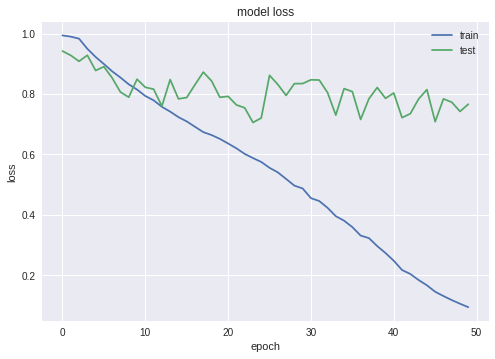

In [11]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

### Augmented dataset (rotation, scaling)

In [53]:
augmentations = (None, 'rotate')

del train_generator
del validation_generator

train_generator = AnnotatedSampledVideoTriplets(train_videos, augmentations=augmentations)
validation_generator = AnnotatedSampledVideoTriplets(validation_videos)

produce triplets: 100%|██████████| 64/64 [00:12<00:00,  5.78it/s]


Preview the dataset augmentation.

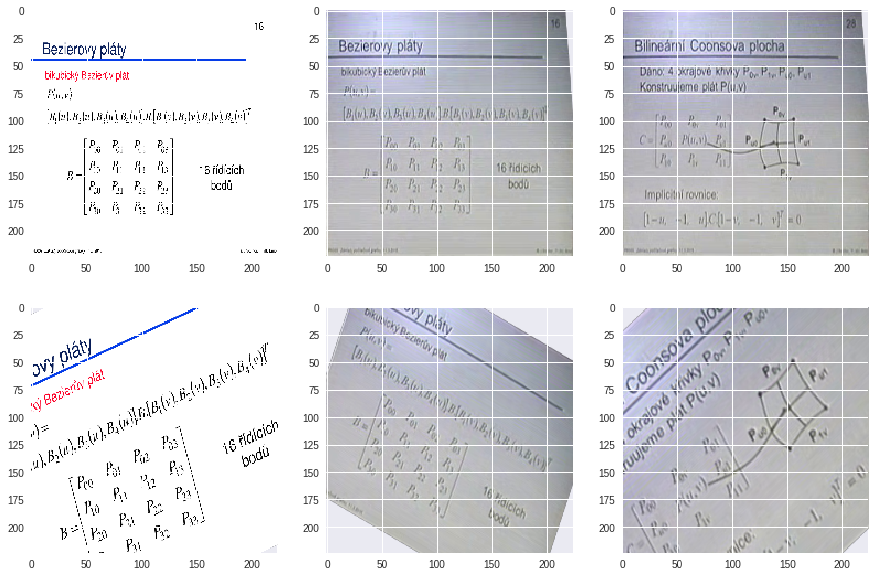

In [54]:
plt.figure(figsize=(15, 10))
for index in range(6):
    plt.subplot(2, 3, index + 1).imshow(train_generator.rgba_images[index])

Train the deep model.

In [55]:
num_epochs = 50

model = deep_rank_model()
model.compile(
    loss=hinge_loss,
    optimizer=SGD(
        lr=0.001,
        momentum=0.9,
        nesterov=True,
    )
)
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=num_epochs,
)

Epoch 1/50
132/132 [==============================] - 104s 788ms/step - loss: 0.9912 - val_loss: 0.9409
Epoch 2/50
132/132 [==============================] - 102s 770ms/step - loss: 0.9694 - val_loss: 0.9462
Epoch 3/50
132/132 [==============================] - 102s 770ms/step - loss: 0.9330 - val_loss: 0.9145
Epoch 4/50
132/132 [==============================] - 102s 770ms/step - loss: 0.9044 - val_loss: 0.8852
Epoch 5/50
132/132 [==============================] - 102s 770ms/step - loss: 0.8791 - val_loss: 0.9284
Epoch 6/50
132/132 [==============================] - 102s 771ms/step - loss: 0.8597 - val_loss: 0.9238
Epoch 7/50
132/132 [==============================] - 102s 770ms/step - loss: 0.8389 - val_loss: 0.9668
Epoch 8/50
132/132 [==============================] - 102s 769ms/step - loss: 0.8236 - val_loss: 0.8195
Epoch 9/50
132/132 [==============================] - 102s 769ms/step - loss: 0.8100 - val_loss: 0.8454
Epoch 10/50
132/132 [==============================] - 102s 769m

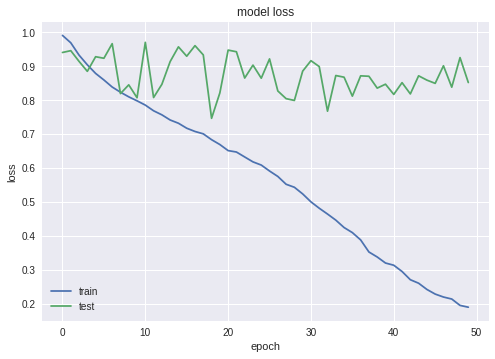

In [56]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()